In [1]:

from torch.utils.data import DataLoader
import torch
import ssl
from Solvers import SolverEmbedding,Loss
from scipy.stats import norm

from Models.EncoderModels import TextEncoder,TransferLearningALBERT,TextEncoder2
from config import cfg
from dataEmbedding.dataEmbedding import Read_Load_BuildBatch
from dataEmbedding.dataEmbeddingLoader import GenerateDataLoader,check_dataset,collate_embedding
from dataEmbedding.generateEmbedding import build_embeedings_CWGAN
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
import pickle
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

device=cfg.DEVICE
print(device)
torch.manual_seed(cfg.SEED)
np.random.seed(cfg.SEED)
PYTORCH_ENABLE_MPS_FALLBACK=1
#for mac os fix 
ssl._create_default_https_context = ssl._create_unverified_context

cpu


In [2]:
stanData=Read_Load_BuildBatch(cfg.EMBEDDING_BATCH_SIZE)

Median of list is : 14.0
Mean: 16.307937873199133


Text(0.5, 1.0, 'Fit Values: 16.31 and 8.50')

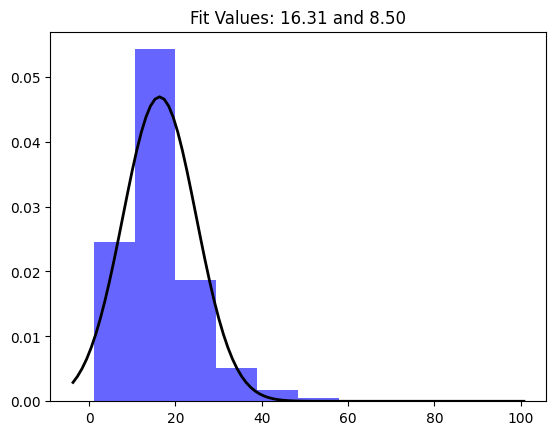

In [3]:
stanData.wordlens.sort()
mid = len(stanData.wordlens) // 2
res = (stanData.wordlens[mid] + stanData.wordlens[~mid]) / 2
print("Median of list is : " + str(res))
print("Mean: "+ str(sum(stanData.wordlens)/len(stanData.wordlens)))

mu, std = norm.fit(stanData.wordlens) 
  
# Plot the histogram.
plt.hist(stanData.wordlens, density=True, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

In [3]:
criterion={
        #'metric_main': Loss.InstanceMetricLoss(device=cfg.DEVICE),
        'metric_separator': Loss.TripletLoss(device=cfg.DEVICE),
        'metric_main':Loss.NPairLoss(device=cfg.DEVICE),
        #'metric_separator':Loss.customSimilarityLoss()
        }

if cfg.EMBEDDING_ALBERT:
    TextModel=TransferLearningALBERT()
    for i in TextModel.parameters():
        i.requires_grad_=False
else:
    TextModel=TextEncoder2(len(stanData.dict_word2idx))
TextModel=TextModel.to(device)

optimizer = torch.optim.Adam(TextModel.parameters(), lr=cfg.EMBEDDING_LR, weight_decay=cfg.EMBEDDING_WEIGHT_DC)
history=SolverEmbedding.Solver(TextModel,stanData,optimizer,criterion,cfg.EMBEDDING_BATCH_SIZE,'online',device)

In [4]:
history.train(cfg.EMBEDDING_EPOCH_NR,stanData.dict_idx2word)

Epoch [1/20] starting...

Training...


0it [00:00, ?it/s]

In [5]:
loader={'train' : GenerateDataLoader(stanData.train,stanData.data_dir,stanData.dict_word2idx),
        'test' : GenerateDataLoader(stanData.test,stanData.data_dir,stanData.dict_word2idx),
        'val':GenerateDataLoader(stanData.val,stanData.data_dir,stanData.dict_word2idx)}

dataloader = {
            'train': DataLoader(
                loader['train'], 
                batch_size=cfg.EMBEDDING_BATCH_SIZE * 2,              
                drop_last=check_dataset(loader['train'], cfg.EMBEDDING_BATCH_SIZE * 2),
                collate_fn=collate_embedding,
                num_workers=4
            ),
            'val': DataLoader(
                loader['val'], 
                batch_size=cfg.EMBEDDING_BATCH_SIZE*2,
                collate_fn=collate_embedding,
                num_workers=4
            ),
            'test': DataLoader(
                loader['test'], 
                batch_size=cfg.EMBEDDING_BATCH_SIZE*2,
                collate_fn=collate_embedding
                #num_workers=2
            )
    }   
build_embeedings_CWGAN(cfg.EMBEDDING_TEXT_MODELS_PATH,TextEncoder(len(stanData.dict_word2idx)),dataloader,cfg.EMBEDDING_SAVE_PATH,cfg.DEVICE)


AttributeError: 'Read_Load_BuildBatch' object has no attribute 'data_dir'

In [3]:
with open('./../GeneratedEmbeddings/train.p', 'rb') as pickle_file:
    tmp=pickle.load(pickle_file)

simMat=np.zeros([len(tmp),128])
textList=[]
for i,elem in enumerate(tmp):
    simMat[i]=elem[2]
    values = [stanData.dict_idx2word[key] for key in elem[3].tolist() if key!=0]
    textList.append(' '.join(values))
    
with open('./../GeneratedEmbeddings/test.p', 'rb') as pickle_file:
    tmp=pickle.load(pickle_file)

simMatTest=np.zeros([len(tmp),128])
textListTest=[]
for i,elem in enumerate(tmp):
    simMatTest[i]=elem[2]
    values = [stanData.dict_idx2word[key] for key in elem[3].tolist() if key!=0]
    textListTest.append(' '.join(values))
    

In [4]:
patternIdx=4
similarIndex=cKDTree(simMat).query(simMatTest[patternIdx], k=1)[1]

In [5]:
print(textList[similarIndex])
print(textListTest[patternIdx])

a light green single seat chair with a raise surface for use in bar
a metal chair with wire type of seat and back rest brown in color
